### Read in data

In [2]:
# import packages 
import os
from toolz import pipe
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# paths and filenames 
path = os.getcwd()
path_images = path + "\\detectingLines\\skeletons\\"
file_names = os.listdir(path_images)
print("Total files in dir: {0}".format(len(file_names)))

Total files in dir: 11


In [4]:
# read in the first image from the list of files
ret, image = cv2.imreadmulti(path_images+file_names[0], [], cv2.IMREAD_UNCHANGED)
print("Total slices in stack: {0}".format(len(image)))

Total slices in stack: 8


### Pick a skeletonised slice 

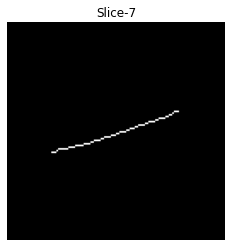

In [5]:
# working wth the seventh slice of this image
img = image[6]
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("Slice-7");

### Hough transform

A straight line parametrised with polar coordinates becomes:  
$$y = \frac{-\cos(\theta)}{\sin(\theta)} x + \frac{\rho}{\sin(\theta)}$$ 
since  
$$\rho = x\ \cos(\theta) + y\ \sin(\theta)$$

In [8]:
# initialise parameter space of all rhos and thetas
n_y, n_x = img.shape[:]
diag = int(np.sqrt(n_x**2 + n_y**2))

# rhos range from -diagnoal to +diagonal of image 
rhos = np.linspace(-diag, diag, 2*diag+1)
n_rhos = len(rhos)

# thetas range from [0, pi] or [-90, 90] radians
#thetas = np.deg2rad(np.arange(-90, 90))
thetas = np.deg2rad(np.arange(0, 180))
cos_theta = np.cos(thetas)
sin_theta = np.sin(thetas)
n_thetas = len(thetas)

# loop through line pixels 
### in this case we know exactly which pixels in fact belong to a line
nonzeros = np.argwhere(img==255)
## scaling nonzeroes - does not make a lot of sense though
#nonzeros_scaled = nonzeros - np.array([[n_y/2, n_x/2]])

In [9]:
# hough transform
x = np.array(nonzeros[:,1])
y = np.array(nonzeros[:,0])
n_xys = nonzeros.shape[0]

theta_mult = np.tile(thetas, n_xys).reshape((n_xys, n_thetas))
cos_theta_mat = np.cos(theta_mult)
sin_theta_mat = np.sin(theta_mult)
#rhos_res = np.mat(x)*np.mat(np.cos(theta_mult)) + np.mat(y)*np.mat(np.sin(theta_mult))
rhos_res = (x.reshape(n_xys,1)*cos_theta_mat) + (y.reshape(n_xys,1)*sin_theta_mat)
### scaling rhos 
#rhos_res = rhos_res+diag

In [10]:
# get frequency of each (theta, rho) pair   
accumulator, theta_vals, rho_vals = np.histogram2d(
    np.tile(thetas, rhos_res.shape[0]),
    rhos_res.ravel(),
    bins=[n_thetas, n_rhos])

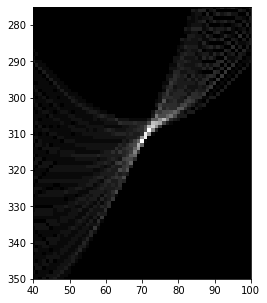

In [11]:
# plot accumulator
plt.figure(figsize = (5,5))
plt.imshow(np.transpose(accumulator), cmap="gray");
plt.xlim(40,100)
plt.ylim(350,275);

In [12]:
# look at accumulator near maximum
accumulator[69:75,304:315]

array([[ 0.,  0.,  1.,  4.,  4.,  5.,  3.,  5., 11., 19., 17.],
       [ 0.,  0.,  1.,  4.,  5.,  5.,  5., 16., 28., 11.,  0.],
       [ 0.,  0.,  1.,  4.,  8.,  9., 26., 26.,  1.,  0.,  0.],
       [ 0.,  0.,  3.,  8., 20., 28., 16.,  0.,  0.,  0.,  0.],
       [ 2.,  3., 10., 21., 23., 15.,  1.,  0.,  0.,  0.,  0.],
       [ 7., 13., 10., 20., 16.,  4.,  0.,  0.,  0.,  0.,  0.]])

In [13]:
# index of maximum in accumulator
ind = np.argwhere(accumulator==np.max(accumulator))[0]
print("Rho = ", rhos[ind[1]])
print("Theta = ", thetas[ind[0]])
print("Min = ", ind)

Rho =  131.0
Theta =  1.2217304763960306
Min =  [ 70 312]


In [14]:
# index of maximum in accumulator - manual
i = np.argmax(accumulator)
x = int(i/363)
y = i % 363 
print(x, y)
print(rhos[y])

70 312
131.0


In [16]:
# get coordinates of line in cartesian coordinates
rho_f = rhos[ind[1]]
theta_f = thetas[ind[0]]
cos_theta_f = np.cos(theta_f)
sin_theta_f = np.sin(theta_f)

xs = np.linspace(0, 127, 128)

intercept = rho_f/sin_theta_f
slope_x = np.array([(-cos_theta_f*xs)/sin_theta_f])

ys = slope_x+intercept

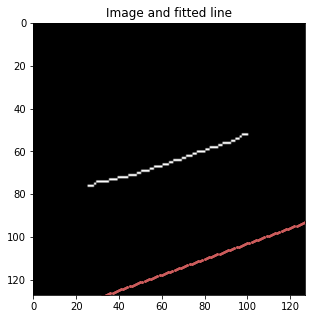

In [17]:
# overlay image with fitted line 
plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")
x = np.array(range(128))
plt.scatter(xs, ys, c="indianred", s=4)
plt.xlim(0,127)
plt.ylim(127,0)
plt.title("Image and fitted line")
plt.show()

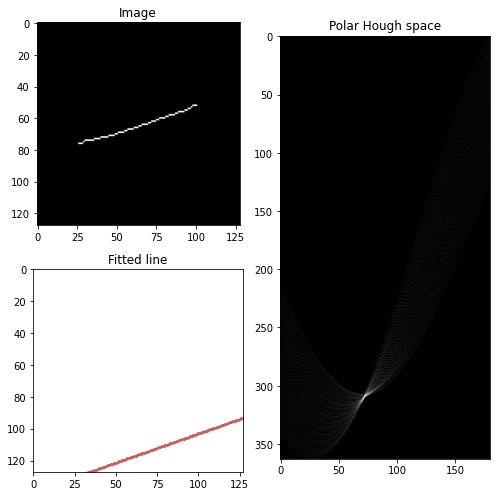

In [18]:
# plot image and pixel data side by side
fig = plt.figure(figsize=(7, 7))

fig.add_subplot(221)
plt.imshow(img, cmap="gray")
#plt.axis("off")
plt.title("Image");

fig.add_subplot(223)
plt.scatter(xs, ys, c="indianred", s=4)
plt.xlim(0,127)
#plt.ylim(0, 128);
plt.ylim(127, 0);
plt.title("Fitted line")

fig.add_subplot(122)
#plt.figure(figsize=(5,7))
plt.imshow(np.transpose(accumulator), cmap="gray");
plt.title("Polar Hough space");

plt.tight_layout()
#plt.savefig("All_plots.png", format="png", dpi=600)

In [ ]:
#np.matmul(np.transpose(np.matrix([2,2,3,3])), np.matrix([10,10,10]))

In [ ]:
#np.matmul(np.transpose(np.array([2,2,3,3])), np.array([10,10,10]))